# Distribution Fitting with Sum of Square Error (SSE)
## find best fit by computing the least/minimum residual sum of squares 

In [1]:
import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
#import statsmodels as sm
import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [
        st.norm,
        st.powerlaw,
        #st.powerlognorm,
        st.powernorm,
        st.weibull_min,
        st.weibull_max,
        st.dweibull,
        st.erlang,
        st.expon,
        st.exponnorm,
        st.exponweib,
        st.logistic,
        st.loggamma,
        st.loglaplace,
        #st.johnsonsb,
        #st.johnsonsu,
        st.skewnorm,
        st.pareto,
        st.pearson3,
        st.beta,
        st.lognorm,
        st.gengamma
        
        
    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse
                    print("distribution: " +str(distribution))
                    print("best_params: " +str(best_params))
                    print("best_sse: " +str(best_sse))

        except Exception:
            pass

    return (best_distribution.name, best_params)

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf



In [2]:
series = pd.read_csv('carton.csv', header=0, index_col=0, squeeze=True)
series = series.drop('Reading ID', axis=1)
series = series.drop('Status', axis=1)
print(series.head())

         Humidity  Temperature  MQ139  TVOC  eCO2 Detector
Time                                                      
0:00:00      43.5         21.3     98     0   400      OFF
0:00:01      43.5         21.3     97     0   400      OFF
0:00:02      43.6         21.4     97     0   400      OFF
0:00:03      43.6         21.4     97     0   400      OFF
0:00:04      43.7         21.4     98     0   400      OFF


In [3]:
series = series.reset_index()

In [4]:
series.iloc[:,5]

0       400
1       400
2       400
3       400
4       400
       ... 
325    8163
326    8076
327    8070
328    8076
329    7925
Name: eCO2, Length: 330, dtype: int64

In [5]:
data = series.iloc[:,5]
data

0       400
1       400
2       400
3       400
4       400
       ... 
325    8163
326    8076
327    8070
328    8076
329    7925
Name: eCO2, Length: 330, dtype: int64

In [6]:
data.describe()

count     330.000000
mean     2986.784848
std      2499.204611
min       400.000000
25%       593.000000
50%      2544.500000
75%      4781.000000
max      8215.000000
Name: eCO2, dtype: float64

array([122.,  12.,  22.,   6.,  23.,   7.,  27.,  19.,  22.,   7.,  10.,
        14.,   6.,  21.,  12.])

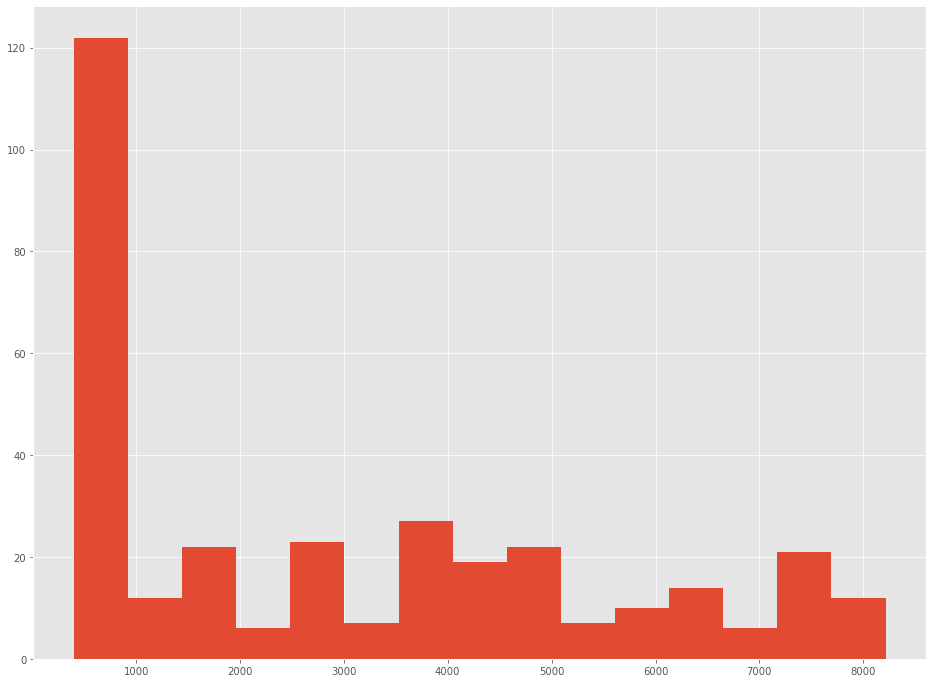

In [7]:
hist, bins, _ = plt.hist(data, bins = 15)
hist

In [8]:
bins

array([ 400.,  921., 1442., 1963., 2484., 3005., 3526., 4047., 4568.,
       5089., 5610., 6131., 6652., 7173., 7694., 8215.])

#### histogram on log scale. 
#### Use non-equal bin sizes, such that they look equal on log scale.
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
#logbins = np.geomspace(data.min(), data.max(), 200) 
plt.subplot(212)
plt.hist(data, bins=logbins)
plt.xscale('log')
plt.show()

distribution: <scipy.stats._continuous_distns.norm_gen object at 0x000001D783D169A0>
best_params: (2986.7848484848487, 2495.4150645972536)
best_sse: 2.5124954746771705e-05
distribution: <scipy.stats._continuous_distns.powerlaw_gen object at 0x000001D783DD3B20>
best_params: (0.4514785490380638, 399.9999999999999, 7845.79021086211)
best_sse: 1.3400807578773745e-05
distribution: <scipy.stats._continuous_distns.exponweib_gen object at 0x000001D783D58A60>
best_params: (6.845162155544001, 0.1338264221595243, 399.99999999999994, 0.8726463386730332)
best_sse: 6.986666475369561e-06


Text(0, 0.5, 'Frequency')

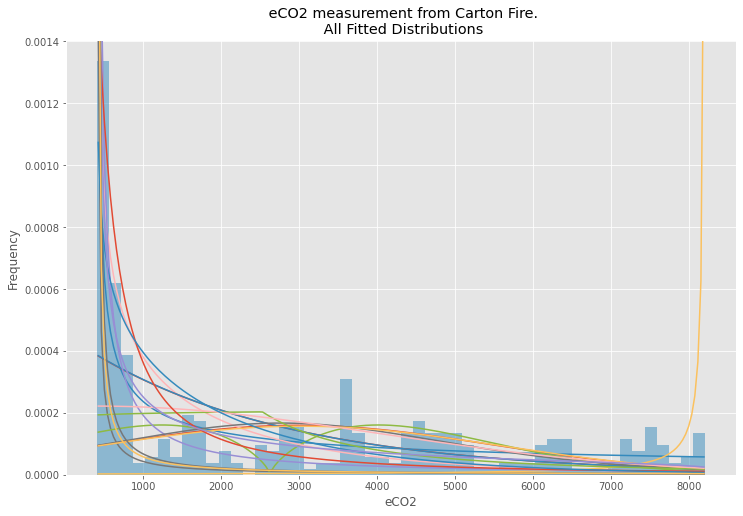

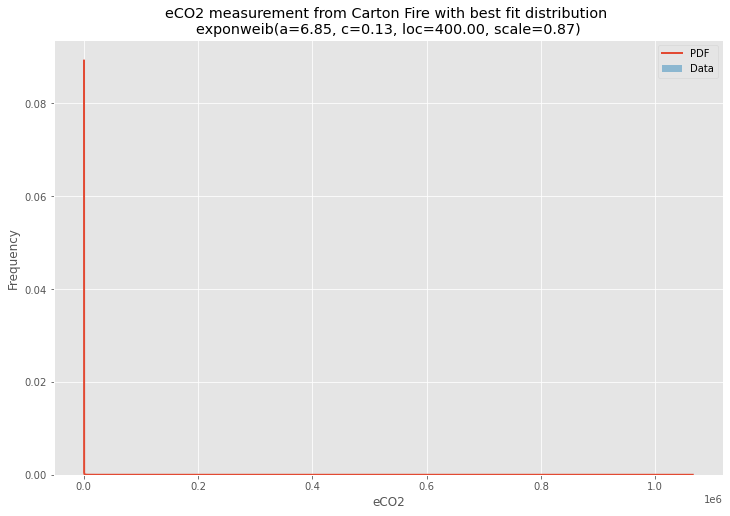

In [9]:

# Plot for comparison
plt.figure(figsize=(12,8))
#ax = data.plot(kind='hist', bins=50, normed=True, alpha=0.5) #, color=plt.rcParams['axes.prop_cycle'][1]

ax = data.plot(kind='hist', bins=50, density=True, alpha=0.5,  
               color=list(matplotlib.rcParams['axes.prop_cycle'])[1]['color'])

# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_fit_name, best_fit_params = best_fit_distribution(data, 200, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u' eCO2 measurement from Carton Fire.\n All Fitted Distributions')
ax.set_xlabel(u'eCO2')
ax.set_ylabel('Frequency')

# Make PDF with best params 
pdf = make_pdf(best_dist, best_fit_params)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title(u'eCO2 measurement from Carton Fire with best fit distribution \n' + dist_str)
ax.set_xlabel(u'eCO2')
ax.set_ylabel('Frequency')